In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import glob
from copy import deepcopy

# from pymatgen.core import Structure
# from pymatgen.io.vasp.outputs import Vasprun
# from pymatgen.analysis.diffusion.analyzer import DiffusionAnalyzer
# from pymatgen.analysis.diffusion.aimd.van_hove import VanHoveAnalysis, EvolutionAnalyzer

from sklearn.linear_model import LinearRegression 

# PCF

In [4]:
file = open('MD-VASP/v2/LLZO_Ia3d_Al20_run0/PCDAT', 'r')
lines = file.readlines()
pcskal = float(lines[8])
pcfein = float(lines[9])
PCF = lines[12:]
PCF = np.array(PCF, dtype='float')
r = np.arange(PCF.size)*(pcskal/pcfein)*1e10
file.close()

[]


ValueError: min() arg is an empty sequence

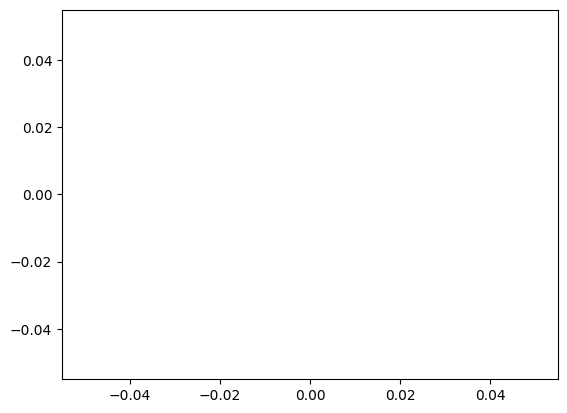

In [3]:
plt.plot(r, PCF)
plt.plot([min(r), max(r)], [1, 1], color='black')
plt.xlabel('Radial Distance (angstroms)')
plt.xlim([min(r), max(r)])
plt.ylim([min(PCF), max(PCF)+.1])
plt.ylabel('PCF')
plt.title('Pair Correlation Function')
plt.axvline(1.38, color='black')
plt.show()

# Relaxation Convergence

Text(0, 0.5, 'Potential Energy (eV)')

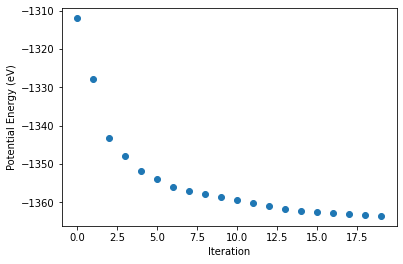

In [4]:
with open('Relaxation/LLZO_Ia3d_Al30_initial/LLZO_Ia3d_Al30_partial_relaxed/LLZO_Ia3d_Al30_partial_00.vasp_output', 'r') as f:
    lines = f.readlines()
E_conv = np.array([])
for line in lines:
    if 'E0=' in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        E_conv = np.append(E_conv, float(values[4])*(10**float(values[5])))

plt.scatter(range(len(E_conv)), E_conv)
plt.xlabel('Iteration')
plt.ylabel('Potential Energy (eV)')

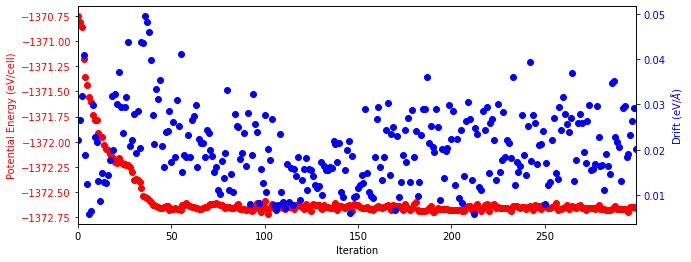

In [2]:
file = open('Relaxation/LLZO_Ia3d_Al00/output_file')
lines = file.readlines()
E = np.array([])
for line in lines:
    if 'E0=' in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        E = np.append(E, float(values[4]) * 10**float(values[5]))
file.close()

file = open('Relaxation/LLZO_Ia3d_Al00/OUTCAR')
lines = file.readlines()
drift = np.array([])
for line in lines:
    if 'total drift' in line:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        drift = np.append(drift, np.sqrt(float(values[0])**2 + float(values[1])**2 + float(values[1])**2))
file.close()

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.scatter(range(len(E)), E, color='red')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Potential Energy (eV/cell)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.scatter(range(len(drift)), drift, color='blue')
ax2.set_ylabel(r'Drift (eV/$\AA$)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.autoscale(enable=True, axis='x', tight=True)

plt.show()

# Structure Selection

23
97


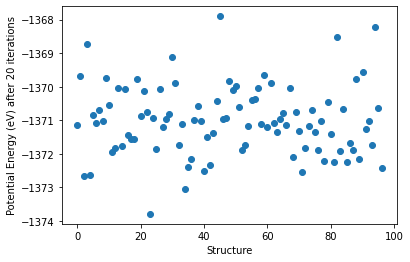

In [2]:
E = np.array([])
for file in sorted(glob.glob('Relaxation/LLZO_Ia3d_Al00_initial/LLZO_Ia3d_Al00_partial_relaxed/LLZO_Ia3d_Al00_partial_*.vasp_output')):
    with open(file, 'r') as f:
        lines = f.readlines()
    E_conv = np.array([])
    for line in lines:
        if 'E0=' in line:
            values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            E_conv = np.append(E_conv, float(values[4])*(10**float(values[5])))
    if len(E_conv) > 0:
        E = np.append(E, E_conv[-1])
    else:
        continue
plt.scatter(range(len(E)), E)
plt.xlabel('Structure')
plt.ylabel('Potential Energy (eV) after 20 iterations')
print(np.argmin(E))
print(len(E))

# Learning Curves

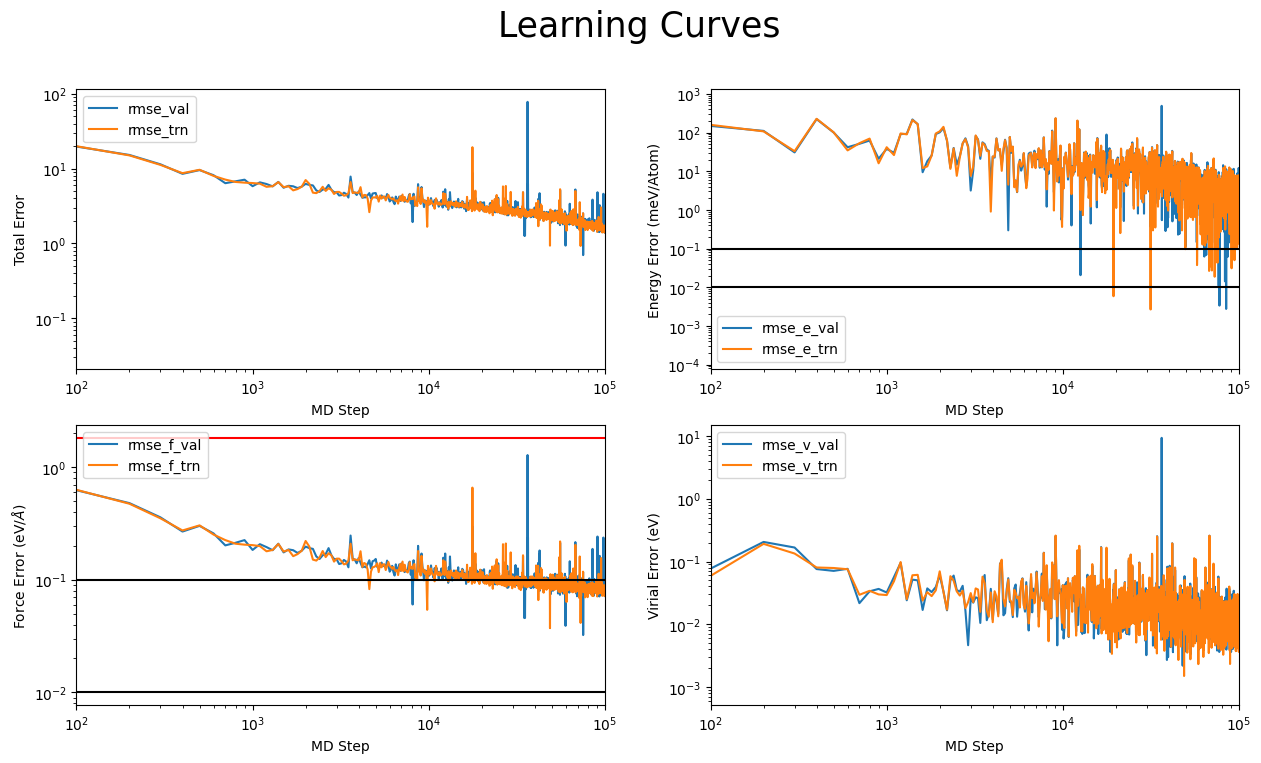

In [8]:
data = np.genfromtxt('Azure/model/lcurve.out', names=True)
fig, axs = plt.subplots(2,2, figsize=(15,8))

axs[0,0].plot(data['step'], data['rmse_val'], label='rmse_val')
axs[0,0].plot(data['step'], data['rmse_trn'], label='rmse_trn')
axs[0,0].legend()
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_xlim([10**2, 10**5])
axs[0,0].set_xlabel("MD Step")
axs[0,0].set_ylabel("Total Error")

axs[0,1].plot(data['step'], data['rmse_e_val']*1000, label='rmse_e_val')
axs[0,1].plot(data['step'], data['rmse_e_trn']*1000, label='rmse_e_trn')
axs[0,1].plot([0, max(data['step'])], [10**-1, 10**-1], color='black')
axs[0,1].plot([0, max(data['step'])], [10**-2, 10**-2], color='black')
axs[0,1].legend()
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_xlim([10**2, 10**5])
axs[0,1].set_xlabel("MD Step")
axs[0,1].set_ylabel("Energy Error (meV/Atom)")

axs[1,0].plot(data['step'], data['rmse_f_val'], label='rmse_f_val')
axs[1,0].plot(data['step'], data['rmse_f_trn'], label='rmse_f_trn')
axs[1,0].plot([0, max(data['step'])], [10**-1, 10**-1], color='black')
axs[1,0].plot([0, max(data['step'])], [10**-2, 10**-2], color='black')
axs[1,0].plot([0, max(data['step'])], [1.82, 1.82], color='red')
axs[1,0].legend()
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_xlim([10**2, 10**5])
axs[1,0].set_xlabel("MD Step")
axs[1,0].set_ylabel(r"Force Error (eV/$\AA$)")

axs[1,1].plot(data['step'], data['rmse_v_val'], label='rmse_v_val')
axs[1,1].plot(data['step'], data['rmse_v_trn'], label='rmse_v_trn')
axs[1,1].legend()
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].set_xlim([10**2, 10**5])
axs[1,1].set_xlabel("MD Step")
axs[1,1].set_ylabel("Virial Error (eV)")

plt.suptitle("Learning Curves", fontsize=25)
plt.show()

In [7]:
force_av = np.array([])
for name in glob.glob('MD-VASP/LLZO_Ia3d_Al*/OUTCAR'):
    f = open(name, 'r')
    force = np.array([])
    while f:
        line = f.readline()
        if line== "":
            break
        if 'TOTAL-FORCE' in line:
            f.readline()
            data = np.array([])
            for i in range(188):
                line = f.readline()
                values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                values = [float(x) for x in values]
                data = np.append(data, np.linalg.norm(values[3:]))
            force = np.append(force, data.mean())
    f.close()
    force_av = np.append(force_av, force.mean())
print(force_av)

[1.81860989 1.83077971 1.81615915]


# LAMMPS Data Processing

In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
def D_func(slope):
    # Slope in A2 /ps
    # Output in     cm2/s
    return (slope / 6) * 10**12 / (10**(8*2))

def N_eff_func(ave_msd, a):
    return max(ave_msd) * 420 / (a**2)

def sigma_func(D, N_mobile_ions, unit_cell_volume, T):
    return ( (D * (10**-2)**2) * (N_mobile_ions/(unit_cell_volume*(10**-10)**3)) * ((1.6e-19)**2) / (1.38e-23*T) ) * (10**3/10**2)

def E_a_func(slope):
    return -slope*(8.62*10**-5)*np.log(10)

In [3]:
dt = 0.001
a = 2.4 # Approx. site hopping length, for use in N_Eff
record_freq = 10
columns = ['Doping Element', 'Doping Concentration (Formulaic)', 
           'Temperature (K)', 'Diffusivity (cm^2/s)', 'Conductivity (mS/cm)', 'Correlation Factor', 
           'N Eff (>500)']
diffusivity = pd.DataFrame(columns=columns)
for element in ['Al']:
    for concentration in [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]:
        for (T, unit_cell_volume) in [(900, 26.18614**3), (1200, 26.28517**3), (1500, 26.38420**3)]:
            # MSD
            ave_msd = []
            for i,file in enumerate(glob.glob('MD-LAMMPS/data/LLZO_Ia3d_%s%02.f/msd*-%.0f.out' % (element, 100*concentration, T))):
                df = pd.read_csv(file, sep=" ")
                pos = np.array(df['Time-averaged'])
                msd = pos[6::5].astype('float64')
                ave_msd.append(msd)
            if not np.any(ave_msd):
                continue
            ave_msd = np.array(ave_msd).mean(axis=0)
            N_eff = N_eff_func(ave_msd, a)
            
            # MSCD
            ave_mscd = []
            for i,file in enumerate(glob.glob('MD-LAMMPS/data/LLZO_Ia3d_%s%02.f/mscd*-%.0f.out' % (element, 100*concentration, T))):
                df = pd.read_csv(file, sep=" ")
                pos = np.array(df['Time-averaged'])
                mscd = pos[6::5].astype('float64')
                ave_mscd.append(mscd)
            if not np.any(ave_mscd):
                continue
            ave_mscd = np.array(ave_mscd).mean(axis=0)
            time = dt*record_freq*np.array(range(ave_msd.shape[0]))
             
            # Fitting D
            model = LinearRegression()
            model.fit(time[int(10/(dt*record_freq)):].reshape(-1,1), ave_msd[int(10/(dt*record_freq)):])
            D = D_func(model.coef_[0])
            N_mobile_ions = 448 - 1200*concentration/5
            sigma = sigma_func(D, N_mobile_ions, unit_cell_volume, T)
            
            
            # Fitting correlation factor
            model.fit(time[int(10/(dt*record_freq)):].reshape(-1,1), ave_mscd[int(10/(dt*record_freq)):])
            Dj = D_func(model.coef_[0])
            corr = D/Dj            

            # Put into total dataframe
            entry = pd.DataFrame([[element, concentration, T, D, sigma, corr, N_eff]], columns=columns)
            diffusivity = pd.concat([diffusivity, entry], ignore_index=True)

,Doping Element,Doping Concentration (Formulaic),Activation Energy (eV),D0 (cm2/s),RT D (cm2/s),Average Correlation
0,Al,0.00,0.258205,608.436765,0.026230,2.987451
1,Al,0.05,0.270531,591.391729,0.015778,2.903362
2,Al,0.10,0.257668,528.408137,0.023261,2.956657
3,Al,0.15,0.251300,488.962715,0.027581,2.826498
4,Al,0.20,0.281272,532.910077,0.009360,3.054760
5,Al,0.25,0.269750,458.484353,0.012610,3.129987
6,Al,0.30,0.300522,507.171251,0.004210,3.027004
7,Al,0.35,0.313966,533.823744,0.002626,3.025730
8,Al,0.40,0.327923,490.982949,0.001403,3.051026
9,Al,0.45,0.345451,540.126604,0.000780,3.120309


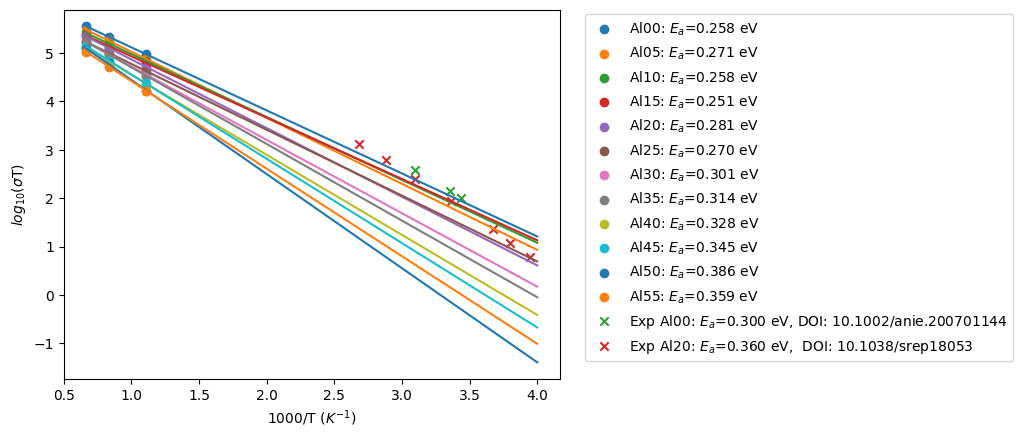

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Simulation
summary_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 'Activation Energy (eV)',
           'D0 (cm2/s)', 'RT D (cm2/s)', 'Average Correlation']
arrhenius = pd.DataFrame(columns=summary_columns)
diffusivity_copy = diffusivity.reset_index()
groups = diffusivity_copy.groupby(['Doping Element', 'Doping Concentration (Formulaic)']).groups
for key in groups:
    group = groups[key]
    group_diffusivity = diffusivity_copy.iloc[group].reset_index()
    filtered_diffusivity = group_diffusivity[group_diffusivity['Temperature (K)'] != 300]

    x = 1./group_diffusivity[['Temperature (K)']]
    y = group_diffusivity['Conductivity (mS/cm)'] * group_diffusivity['Temperature (K)']
    y = np.log10(y.astype('float32'))

    x_filt = 1./filtered_diffusivity[['Temperature (K)']]
    y_filt = filtered_diffusivity['Conductivity (mS/cm)'] * filtered_diffusivity['Temperature (K)']
    y_filt = np.log10(y_filt.astype('float32'))

    corr = np.array(group_diffusivity['Correlation Factor'])

    model = LinearRegression()
    model.fit(x_filt, y_filt)
    E_a = E_a_func(model.coef_[0])
    
    D_0 = np.exp(model.intercept_)
    D_RT = D_0 * np.exp(-E_a / (8.62*10**-5 * 298))
    x_prime = np.linspace(np.min(x['Temperature (K)']), 4/1000, 100).reshape(-1,1)

    entry = pd.DataFrame([[element, key[1], E_a, D_0, D_RT, np.mean(corr)]], columns=summary_columns)
    arrhenius = pd.concat([arrhenius, entry], ignore_index=True)
    
    plt.scatter(1000*x, y, label=r'%s%02.f: $E_a$=%.3f eV' % (key[0], 100*key[1], E_a))
    plt.plot(1000*x_prime, model.predict(x_prime))
    # for i, label in enumerate(corr):
    #     plt.annotate('%0.2f' % label, (1000*np.array(x)[i]+0.05, y[i]+0.05))

display(arrhenius)

# Experimental Data
exp_diffusivity = pd.DataFrame([['Al', 0, 291, None, 0.337, None, None],
                                ['Al', 0, 298, None, 0.467, None, None], 
                                ['Al', 0, 323, None, 1.190, None, None], 
                               ], columns=columns) 
x = 1000./exp_diffusivity['Temperature (K)']
y = np.log10(exp_diffusivity['Conductivity (mS/cm)'] * exp_diffusivity['Temperature (K)'])
plt.scatter(x, y,
            label=r'%s: $E_a$=%.3f eV, DOI: 10.1002/anie.200701144' % ('Exp Al00', 0.30),
            marker = 'x'
           )

exp_diffusivity = pd.DataFrame([['Al', 0.2, 1000/2.68, None, 3.533, None, None],
                                ['Al', 0.2, 1000/2.88, None, 1.735, None, None],
                                ['Al', 0.2, 1000/3.10, None, 0.751, None, None],
                                ['Al', 0.2, 1000/3.36, None, 0.293, None, None],
                                ['Al', 0.2, 1000/3.67, None, 0.084, None, None],
                                ['Al', 0.2, 1000/3.80, None, 0.045, None, None],
                                ['Al', 0.2, 1000/3.95, None, 0.024, None, None],
                               ], columns=columns) 
x = 1000./exp_diffusivity['Temperature (K)']
y = np.log10(exp_diffusivity['Conductivity (mS/cm)'] * exp_diffusivity['Temperature (K)'])
plt.scatter(x, y,
            label=r'%s: $E_a$=%.3f eV,  DOI: 10.1038/srep18053' % ('Exp Al20', 0.36),
            marker = 'x'
           )

plt.legend(loc=(1.05, 0.05))
plt.xlabel(r'1000/T ($K^{-1}$)')
plt.ylabel(r'$log_{10}$($\sigma$T)')
plt.show()

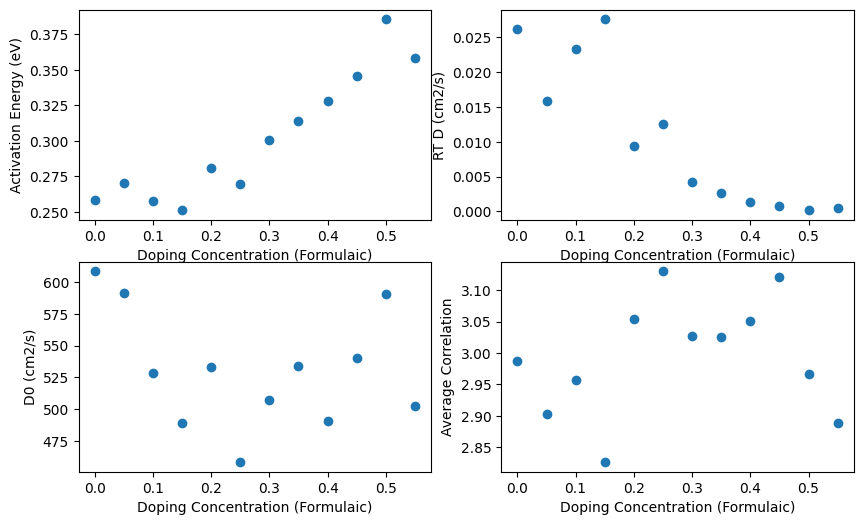

In [5]:
fig, axs = plt.subplots(2,2, figsize=(10,6))

axs[0,0].scatter(arrhenius['Doping Concentration (Formulaic)'], arrhenius['Activation Energy (eV)'])
axs[0,0].set_xlabel('Doping Concentration (Formulaic)')
axs[0,0].set_ylabel('Activation Energy (eV)')

axs[1,0].scatter(arrhenius['Doping Concentration (Formulaic)'], arrhenius['D0 (cm2/s)'])
axs[1,0].set_xlabel('Doping Concentration (Formulaic)')
axs[1,0].set_ylabel('D0 (cm2/s)')

axs[1,1].scatter(arrhenius['Doping Concentration (Formulaic)'], arrhenius['Average Correlation'])
axs[1,1].set_xlabel('Doping Concentration (Formulaic)')
axs[1,1].set_ylabel('Average Correlation')

axs[0,1].scatter(arrhenius['Doping Concentration (Formulaic)'], arrhenius['RT D (cm2/s)'])
axs[0,1].set_xlabel('Doping Concentration (Formulaic)')
axs[0,1].set_ylabel('RT D (cm2/s)')

plt.show()

##### Pure LLZO Correlation Factor at 900K: 3.0

# Testing VASP File Writing

In [17]:
import numpy as np

from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.transformations.standard_transformations import DiscretizeOccupanciesTransformation
from pymatgen.transformations.standard_transformations import AutoOxiStateDecorationTransformation
from pymatgen.transformations.standard_transformations import RemoveSpeciesTransformation
from pymatgen.transformations.advanced_transformations import SQSTransformation

### Manually edit original .cif file

In [20]:
structure = Structure.from_file(filename='structure_files/LLZO_Ia3d_experimental.cif')
analyzer = SpacegroupAnalyzer(structure)
structure = analyzer.find_primitive()

print(structure.composition)
for i,site in enumerate(structure.sites):
    if site.species['Li'] == 0.69:
        structure.sites[i].species = {'Li':1}
    elif site.species['La'] == 0.985:
        structure.sites[i].species = {'La':1}
    elif site.species['Li'] == 0.32:
        structure.sites[i].species = {'Li':0.333}
print(structure.composition)

DOT = DiscretizeOccupanciesTransformation()
structure_dot = DOT.apply_transformation(structure)
AOSDT = AutoOxiStateDecorationTransformation()
structure_aosdt = AOSDT.apply_transformation(structure_dot)
structure_aosdt.to(filename='structure_files/LLZO_Ia3d_experimental_cleaned.cif')

Li23.64 Al0.864 La11.82 Zr8 O48
Li27.984 La12 Zr8 O48


### Get ordered structure from disordered structure

In [21]:
disordered_structure = Structure.from_file('structure_files/LLZO_Ia3d_experimental_cleaned.cif')
for i,site in enumerate(disordered_structure):
    species = site.species.as_dict()
    total = 0
    for elem in species:
        total += species[elem]
    species['H'] = 1-total
    disordered_structure.sites[i].species = species
SQST = SQSTransformation(scaling=1, cluster_size_and_shell={2: 1},
                         search_time=60, directory='.sqs')
ordered_structure = SQST.apply_transformation(disordered_structure)
RST = RemoveSpeciesTransformation('H')
ordered_structure = RST.apply_transformation(ordered_structure)
%cd ..
ordered_structure.to(filename='structure_files/LLZO_Ia3d_ordered.cif')

RuntimeError: run_mcsqs requires first installing AT-AT, see https://www.brown.edu/Departments/Engineering/Labs/avdw/atat/